Code by Piers Walker 2022

## Introduction
This programme has been created to demonstrate the use of Machine Learning to optimise the output of a simulator.<br>

**Business problem being solved: The optimisation of a simulation tool**<br>
A company uses a simulation tool to model business processess, but would like to optimise the components of the model to produce a desired output (e.g. number of widgets manufactured) at the lowest cost.

This notebook demonstrates that a simulator may be treated as a black box whose input-output relationship is learnt by machine-learning regression models.<br>
The regression model can then be searched - significantly much faster than a typical simulation can be run - to determine the best input parameters to achieve a given target output for the lowest cost.
This approach may also be applied to optimise an practical experiment which yields a single measured value.<br>

In this example the value of 5 integer inputs are optimised (e.g. corresponding to the number of manufacturing machines in 5 depots) to produce a target outcome of 80 (e.g. 80 widgets/day throughput).

**Techniques employed:**<br>
1. Generation of complex multi-dimensional function.
2. Machine Learning regression using Sklearn; including train-test-split.
3. Use of ML Pipelines; including data-scaling and polynomial transformations.
4. Hyper-parameter optimisation using deterministic or stochastic grid-search.
5. Global optimisation using Scipy.
6. Data manipulation using Pandas and Numpy.

**Programme Process Steps:**<br>
1. **Input Parameters**<br>
Constants such as the target simulation output value and the costs associated with the input parameters is set by the user.
2. **Run Simulator To Conduct Exploratory Runs**<br>
Runs the simulator with a wide range of random values for each input parameter to obtain and record the associated simulator output.<br> 
The purpose is to generate sufficient data to construct a reliable Machine Learning regression model.<br>
Note: Currently a simulator is emulated; replaced by a function that generates a value for a set of inputs.<br>
3. **Build and Test Regression Models**<br>
A set of different SKLearn regression models are defined within a pipeline, along with example hyper-parameters that could be optimised. Simple linear models such as LinearRegression or Lasso are preceeded by a PolynomialFeatures approach to pre-trasform the data.<br>
The set of regression models are first optimised via cross-validation on the trainng data employing either GridSearchCV or RandomizedSearchCV.<br>
Next the k-fold cross-validation is performed on the training data to generate an 'r-squared' cross_validation score to allow the set of regressors to be ranked.<br>
The top performing regression model is selected and it's performance against the testset is displayed via a true vs predicted value scatter plot.
4. **Derive Predicted Optimal Input Parameters**<br>
The regresion model has now learnt the interaction between the Simulators' inputs and outputs, which is treated as a black-box. This solution-landscape is navigated using the differential_evolution global optimiser from Scipy. Each parameter value may be considered as a resource with an associated cost proportional to the quantity of that parameter - the sum of each parameter cost is summed to generate a total cost associated with the set of inputs. The Optimiser is used to recommend a predicted optimal set of input parameter values to meet a given output target value, for the lowerest cost.
5. **Run Simulator With Concentrated Optimal Runs**<br>
The simulator is run using the predicted optimal set of input parameter values, together with a range of runs in which the values are perturbed by a small random amount to perform a concentrated search around this solution. 
6. **Determine Best Compliant Result**<br>
All the resulting runs are reviewed for their closeness to the target Simulator output (e.g. 60), within a given tolerance (+-0.5). The 'compliant' runs with the lowest costs are presented.

**Process Repetition:**<br>
The group of exploratory and optimal simulation runs are then run repeatedly within a loop to provide continued improvement.

**Comments:**<br>
At the end of each loop the best compliance solutions are presented as a heatmap.<br>

As the loops progress - and more data is fed into the ML model - the better its performance. This may be seen by the closeness of the predicted output of the optimal array in Step 4, and the actual output determined in Step 5. It is also shown by the 'Regression Model Performance Against Unseen Test Data' scatter plot.<br>

Also presented at the end of each loop is a chart demonstrating the reduction in the cost of the best compliant solution as a function of loop number.

## Import Libraries

In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # to format plot axes
from matplotlib import cm # For surface plot colour-map
import seaborn as sns # for heatmap
from datetime import datetime # to print date

import random
from random import randint # to generate random values
import os.path # to manipulate files

import warnings
#warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore')

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Optimisation
from scipy.optimize import differential_evolution

## Load Functions

In [2]:
def objective_function(x,*args):
    '''Generates an output cost value composed of closeness to target value squared and feature costs.
       Function required by optimisation
    
    INPUTS
        x (array of floats): Array to be optimised

        args[0] (regressor object): fitted regressor
        args[1] (float):target 
        args[2] (list of floats):cost
        args[3] (float): weight to multiply target difference value by
    
    RETURNS
        result(float)
        
    '''
    # Unpack args
    regressor = args[0]
    target = args[1]
    feature_costs = args[2]
    diff_error_weight = args[3]
      
    # Make prediction, compare against target and generate squared error
    diff_error = (regressor.predict([x])[0] - target)**2
    
    # Calculate cost error
    cost_error = np.sum(np.multiply(x,feature_costs))
    
    return cost_error + diff_error*diff_error_weight

### Emulator Functions
Instead of a simulator a emulator may be used - This artifical function converts multiple feature inputs to a single output

Plot example function shape over two-dimensions
funct_list: ['funct_sqrt']


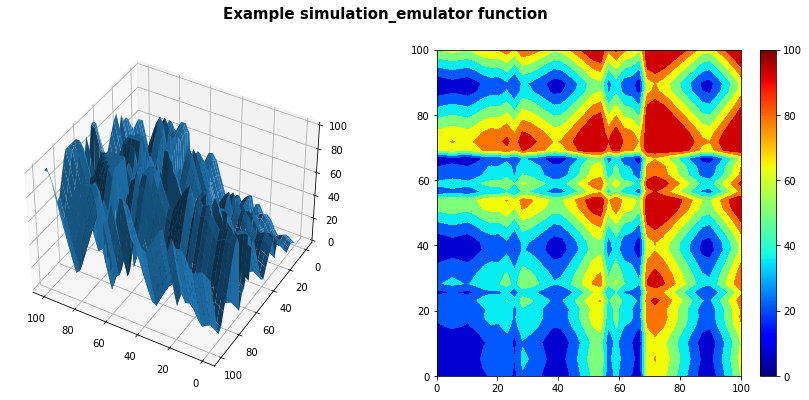

In [9]:
def funct_sqrt(x):
    return np.sqrt(x)

def funct_rand_nthroot(x,seed=0):
    random.seed(seed)
    n = (5-0.5)*np.random.rand()+0.5
    return np.power(x,(1/n))

def funct_power2(x):
    return x**2

def funct_exp(x):
    return np.exp(x/20)

def funct_humps(x):
    return np.clip(200*np.sin(x/10),0,200)
    
#--------------------------------------------------------------------------------------------------
def simulation_emulator(inputs,funct_list=[funct_humps],scale=100,seed=0):  
    ''' Function generator; accepting multiple input values and returing a single performance metric.
        Purpose is to emulate the interactions within a complicated simulation of business processes; 
        Thus the output is a complex function of the inputs.
    PARAMETERS
    inputs (list of floats): The input parameter values eg quantities of different resourses.
                             Note: Code calling this function may assume values to be ints
    funct_list (list of functions): Selection of functions to transform the input parameters e.g. [funct_sqrt]
    scale (float): Scales output result by clipping to this value
    seed (float): value to seed random function
    
    RETURNS
    single value (float) representing simualtion output
    '''  
    random.seed(seed)
    
    result = 0
    for i in range(len(inputs)): 
        rand_int = randint(0,len(funct_list)-1)
        result = result + inputs[i]*abs(np.sin(np.tan(funct_list[rand_int](inputs[i]))))
        #result = result + funct_list[rand_int](inputs[i])/10 # Simple alternative
    
    return np.clip(result,0,scale)

#--------------------------------------------------------------------------------------------------
print('Plot example function shape over two-dimensions')

funct_list=[funct_sqrt]
print(f'funct_list: {[f.__name__ for f in funct_list]}')

x = y = np.linspace(0, 100, 40)
X, Y = np.meshgrid(x, y)
zs = np.array([simulation_emulator(inputs=[x,y],funct_list=funct_list) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122)

ax.plot_surface(X, Y, Z,lw=3)
#ax.plot_wireframe(X, Y, Z, color='w',lw=0.4)
ax1.contourf(X, Y, Z, zdir ='z',offset = -10,cmap = 'jet')

m = cm.ScalarMappable(cmap='jet')
m.set_array(np.linspace(min(zs), max(zs), 40))
fig.colorbar(m,ax=ax1)

ax.view_init(40, 120)
fig.suptitle('Example simulation_emulator function',fontsize=15,weight='bold');

## Set Run Parameters
Constants such as the target simulation output value and the costs associated with the input parameters are set by the user.

In [211]:
funct_list = [funct_sqrt]
#funct_list = [funct_sqrt,funct_power2,funct_humps,funct_exp,funct_rand_nthroot]

# Set the resource costs. 
# Note: The length of this is used to calc the number of features
feature_costs = [10,15,20,25,30] # [randint(20,50) for x in range(5)]

# Set the bounds on the feature values. Only int values between these limits will be tried.
feature_mins = [0]*len(feature_costs)
feature_maxs = [40]*len(feature_costs)

# Set the target value and the closeness criteria
target = 60 # The algorithm will find inputs that yield an output of this value
target_tolerance = 0.5 # Any output within +- this tolerance from the target value is deemed valid 

#----------------------------------------------------------
# Number of times the exploratory + optimal run sets are repeated
num_loops = 8

# ----------------------------------------------------------
# Set number of exploratory runs - This number of runs with random input values will be tested 
num_exploratory_runs = 300

# ----------------------------------------------------------
# Optimising regressors with grid search
cv_scoring ='r2' # also used for k-fold assessment
search_type = 'random' # 'grid / 'random'
randomizedsearch_cv_n_iter = 50

# ----------------------------------------------------------
# k-fold assessment of regressors
n_kfold_splits = 3

# ----------------------------------------------------------
# Regressor optimisation objective function weight 
diff_error_weight = 10^6 # obj = cost_error + diff_error*diff_error_weight
optimsation_diff_evol_maxiter = 10 # number of max iterations for differential_evolution optimiser

# ----------------------------------------------------------
# Set number of optimal runs - This number of runs around the predicted best input values will be tested
num_optimal_runs = 200
# Set amount that optimal solution is perturbed to try alternatives
optimal_rand_int_perturbation = 10

In [212]:
# Create dictionary of all the regression pipes, with initial values and gridsearch params
regressor_pipe_all_dict = {}

# regressor_pipe_all_dict['linear_poly'] = {'regressor_pipe':Pipeline([('scaler',MinMaxScaler()),
#                                                                 ('poly',PolynomialFeatures(degree=3)),
#                                                                 ('model',LinearRegression())]),
#                                           'pipe_search_params':{'poly__degree':np.arange(2,4)}}

# regressor_pipe_all_dict['ridge_poly'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
#                                                                 ('poly',PolynomialFeatures(degree=3)),
#                                                                 ('model',Ridge())]),
#                                           'pipe_search_params':{'poly__degree':np.arange(2,4)}}

# regressor_pipe_all_dict['lasso_poly'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
#                                                                 ('poly',PolynomialFeatures(degree=2)),
#                                                                 ('model',Lasso())]),
#                                           'pipe_search_params':{'poly__degree':np.arange(2,4)}}

# regressor_pipe_all_dict['kernel_ridge'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
#                                                                 ('model',KernelRidge(kernel='poly'))]),
#                                           'pipe_search_params':{'model__kernel':['rbf','poly']}}

regressor_pipe_all_dict['svr'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
                                                                ('model',SVR(kernel='poly'))]),
                                  'pipe_search_params':{'model__kernel':['rbf','poly']}}

regressor_pipe_all_dict['knn'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
                                                                ('model',KNeighborsRegressor(n_neighbors = 3))]),
                                  'pipe_search_params':{'model__n_neighbors':np.arange(2,6)}}

# regressor_pipe_all_dict['random_forrest'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
#                                                                 ('model',RandomForestRegressor(n_estimators = 50))]),
#                                              'pipe_search_params':{'model__n_estimators':[50,100],
#                                                                    'model__max_depth': np.arange(3, 5)}}

# regressor_pipe_all_dict['gradientboost'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
#                                                                 ('model',GradientBoostingRegressor(n_estimators = 50))]),
#                                            'pipe_search_params':{'model__n_estimators':[50,100,150]}}

regressor_pipe_all_dict['hist_gradientboost'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
                                                                ('model',HistGradientBoostingRegressor(max_iter = 100,
                                                                                                      max_leaf_nodes=31))]),
                                                 'pipe_search_params':{'model__max_leaf_nodes':[20,30,40]}}

# regressor_pipe_all_dict['mlp'] = {'regressor_pipe':Pipeline([('scaler',StandardScaler()),
#                                                                 ('model',MLPRegressor(max_iter = 500))]),
#                                   'pipe_search_params':{}}

## Run

In [213]:
# Reset data
if os.path.exists('run_results.csv'):
    os.remove('run_results.csv')

Program started 2022-03-21 12:35:00
- target: 60 (tol: 0.5)

loop: 1

Step 1: running 300 exploratory runs
- complete 2022-03-21 12:35:01

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,36,17,32,3,1,49.871507,1360
296,23,1,22,40,34,53.676813,2705
297,25,19,9,39,15,28.356626,2140
298,20,34,27,9,30,84.732209,2375
299,23,4,6,32,3,42.456347,1300



- the current best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
129,33,23,22,5,40,60.150247,2440
290,32,36,34,38,19,59.859165,3060



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:35:10

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:35:11


,cv_mean,cv_std
hist_gradientboost,0.713383,0.013501
knn,0.492198,0.058059
svr,0.258673,0.018008


- best_regressor: hist_gradientboost


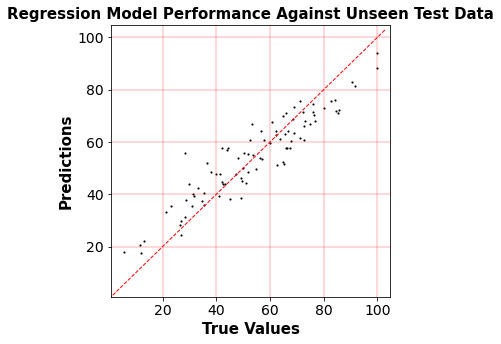


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:35:30
 - results:
   optimal int array: [30, 30, 2, 6, 0]
   predicted optimal output: 59.0909

Step 5: running 200 optimal runs
   (actual output value: 56.3295)
- results saved to run_results.csv
- complete 2022-03-21 12:35:31

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
129,33,23,22,5,40,60.150247,2440
290,32,36,34,38,19,59.859165,3060



- results scatter plot


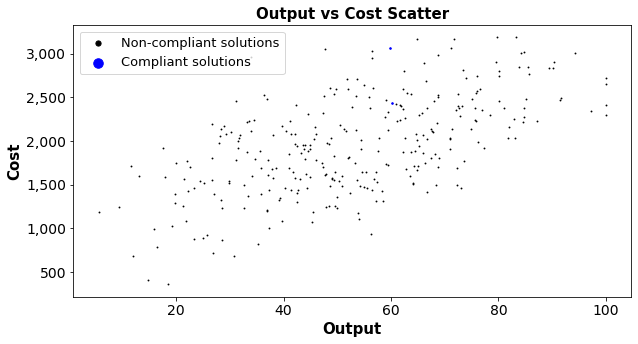

- presenting reduction in compliant solution costs over time


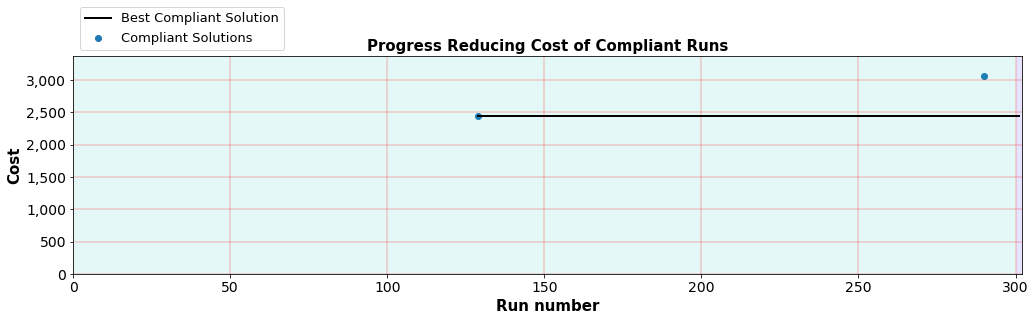

- presenting heatmap of top compliant solutions


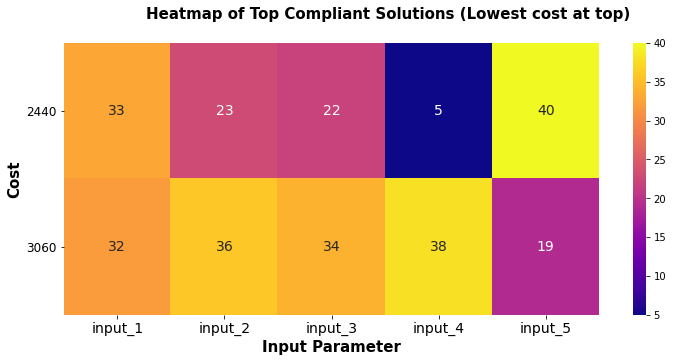


loop: 2

Step 0: imported 302 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
129,33,23,22,5,40,60.150247,2440
290,32,36,34,38,19,59.859165,3060



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:35:33

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,37,21,22,18,28,94.604788,2415
296,32,39,28,39,36,62.468822,3520
297,3,7,13,34,31,49.796813,2175
298,9,3,32,17,31,63.495361,2130
299,25,33,19,26,26,65.341219,2555


- improvements in compliant results have been found:


,input_1,input_2,input_3,input_4,input_5,output,cost
435,2,14,31,23,16,60.454109,1905
484,24,1,21,39,17,60.062599,2160
536,34,13,3,26,32,60.158845,2205
341,6,33,16,13,34,59.757085,2220
382,13,34,22,34,10,60.166855,2230
446,25,37,16,13,27,59.794392,2260
347,15,35,27,38,5,59.682681,2315



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:35:49

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:35:51


,cv_mean,cv_std
hist_gradientboost,0.828759,0.031458
knn,0.481441,0.031219
svr,0.433410,0.016202


- best_regressor: hist_gradientboost


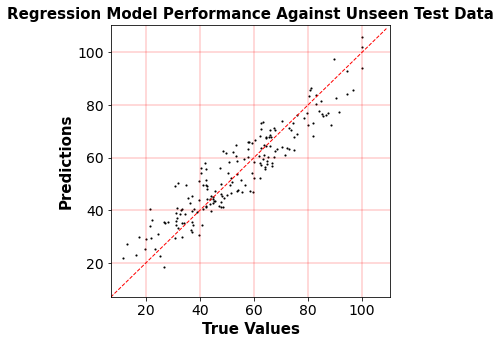


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:36:07
 - results:
   optimal int array: [27, 30, 5, 1, 1]
   predicted optimal output: 59.3932

Step 5: running 200 optimal runs
   (actual output value: 58.2055)
- results saved to run_results.csv
- complete 2022-03-21 12:36:08

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
435,2,14,31,23,16,60.454109,1905
484,24,1,21,39,17,60.062599,2160
536,34,13,3,26,32,60.158845,2205
341,6,33,16,13,34,59.757085,2220
382,13,34,22,34,10,60.166855,2230



- results scatter plot


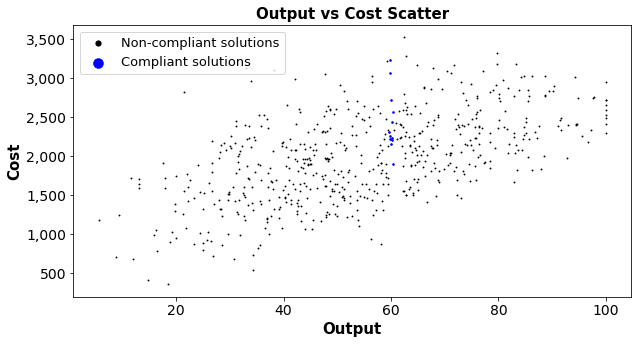

- presenting reduction in compliant solution costs over time


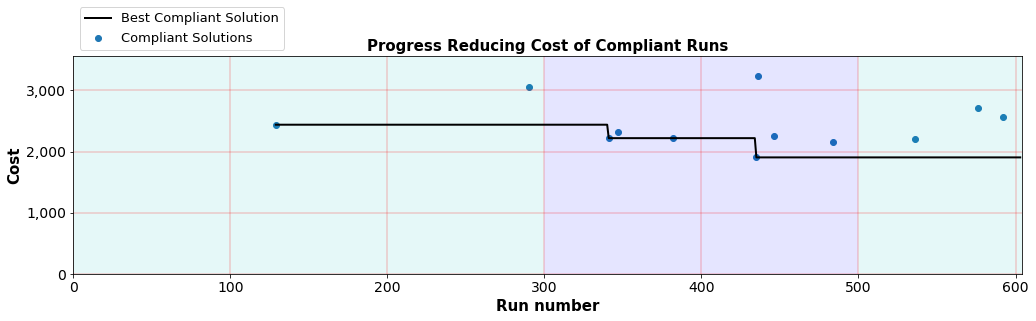

- presenting heatmap of top compliant solutions


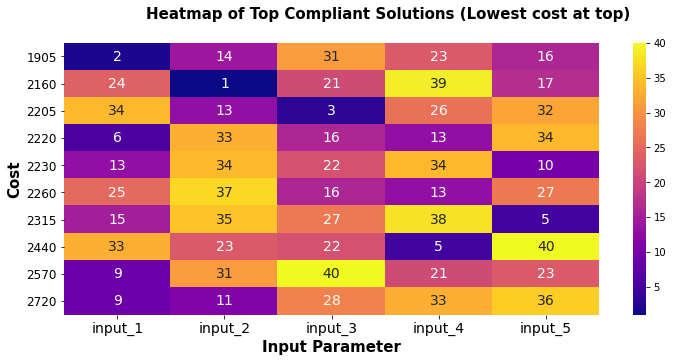


loop: 3

Step 0: imported 604 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
435,2,14,31,23,16,60.454109,1905
484,24,1,21,39,17,60.062599,2160
536,34,13,3,26,32,60.158845,2205
341,6,33,16,13,34,59.757085,2220
382,13,34,22,34,10,60.166855,2230



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:36:11

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,38,8,13,14,28,50.131363,1950
296,20,33,17,6,38,60.620473,2325
297,8,30,1,18,19,53.979536,1570
298,30,36,18,3,13,59.459623,1665
299,15,0,36,8,17,41.552647,1580


- improvements in compliant results have been found:


,input_1,input_2,input_3,input_4,input_5,output,cost
658,15,29,6,3,34,59.996492,1800



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:36:34

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:36:37


,cv_mean,cv_std
hist_gradientboost,0.863780,0.010801
knn,0.508989,0.022687
svr,0.456401,0.024164


- best_regressor: hist_gradientboost


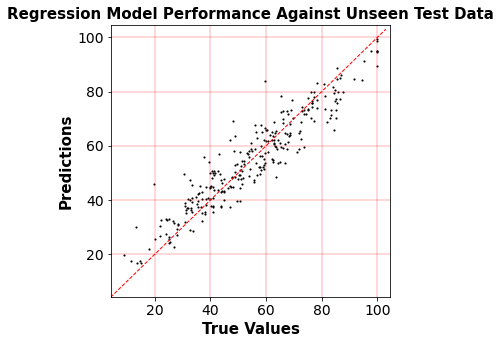


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:36:55
 - results:
   optimal int array: [32, 30, 7, 5, 2]
   predicted optimal output: 55.8623

Step 5: running 200 optimal runs
   (actual output value: 55.5754)
- results saved to run_results.csv
- complete 2022-03-21 12:36:56

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
658,15,29,6,3,34,59.996492,1800
435,2,14,31,23,16,60.454109,1905
614,26,22,40,16,5,59.520368,1940
836,6,2,16,35,28,60.285181,2125
484,24,1,21,39,17,60.062599,2160



- results scatter plot


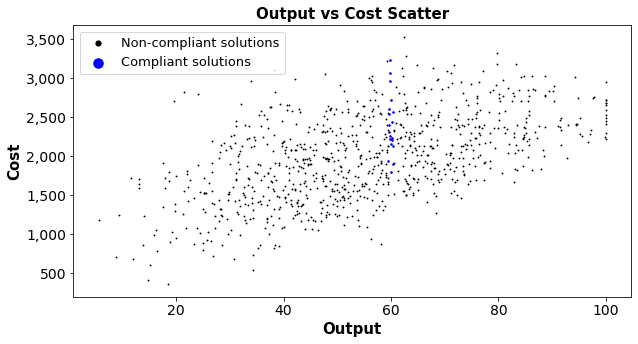

- presenting reduction in compliant solution costs over time


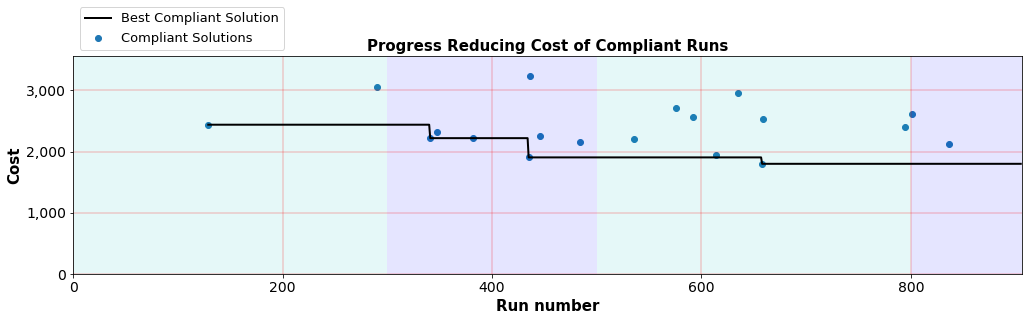

- presenting heatmap of top compliant solutions


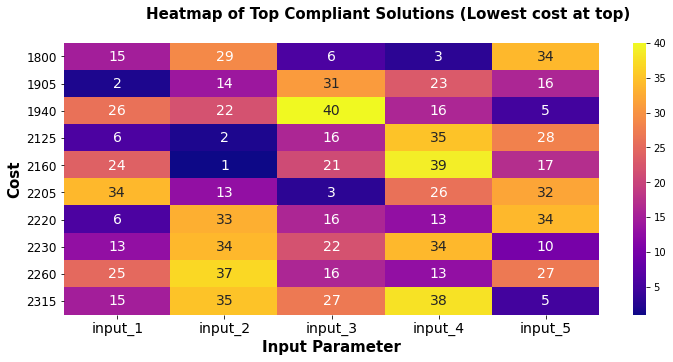


loop: 4

Step 0: imported 906 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
658,15,29,6,3,34,59.996492,1800
435,2,14,31,23,16,60.454109,1905
614,26,22,40,16,5,59.520368,1940
836,6,2,16,35,28,60.285181,2125
484,24,1,21,39,17,60.062599,2160



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:36:59

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,19,29,15,22,33,87.776993,2465
296,28,33,38,1,25,57.982736,2310
297,26,0,34,32,11,55.451304,2070
298,10,5,9,15,3,18.399214,820
299,34,19,34,11,0,41.632310,1580


- improvements in compliant results have been found:


,input_1,input_2,input_3,input_4,input_5,output,cost
1198,31,12,8,19,22,60.073709,1785



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:37:28

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:37:30


,cv_mean,cv_std
hist_gradientboost,0.872653,0.012224
knn,0.542596,0.035502
svr,0.515793,0.025431


- best_regressor: hist_gradientboost


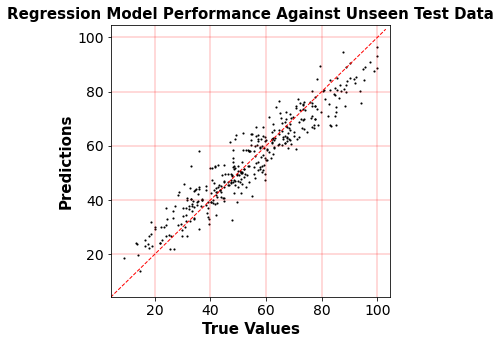


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:37:46
 - results:
   optimal int array: [27, 27, 8, 4, 2]
   predicted optimal output: 58.3967

Step 5: running 200 optimal runs
   (actual output value: 56.9585)
- results saved to run_results.csv
- complete 2022-03-21 12:37:47

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1198,31,12,8,19,22,60.073709,1785
658,15,29,6,3,34,59.996492,1800
1041,31,2,37,28,1,60.216742,1810
435,2,14,31,23,16,60.454109,1905
614,26,22,40,16,5,59.520368,1940



- results scatter plot


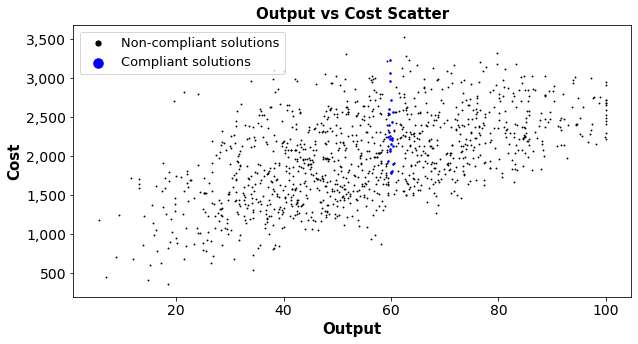

- presenting reduction in compliant solution costs over time


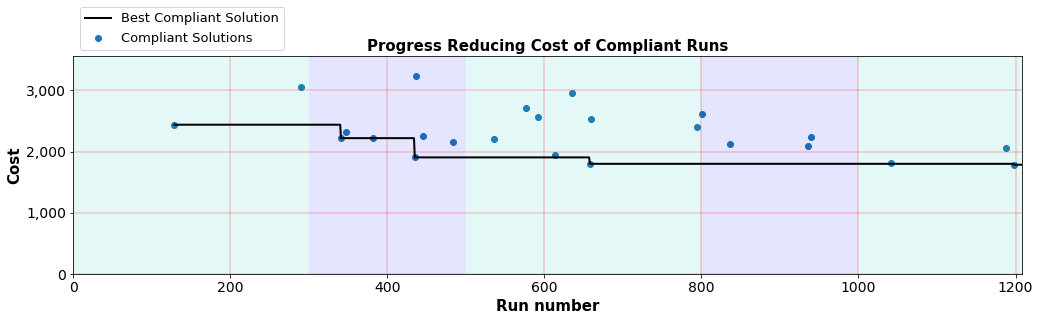

- presenting heatmap of top compliant solutions


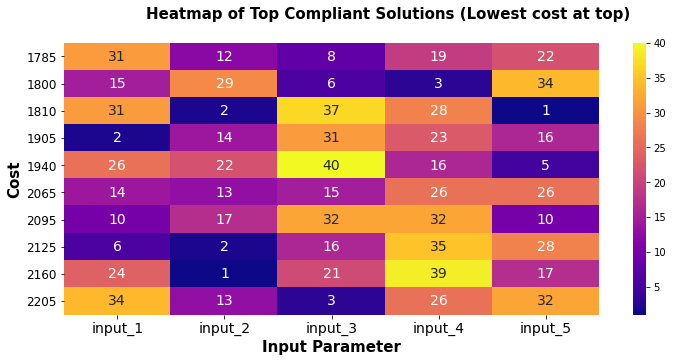


loop: 5

Step 0: imported 1208 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1198,31,12,8,19,22,60.073709,1785
658,15,29,6,3,34,59.996492,1800
1041,31,2,37,28,1,60.216742,1810
435,2,14,31,23,16,60.454109,1905
614,26,22,40,16,5,59.520368,1940



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:37:50

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,11,16,31,31,17,80.890645,2255
296,19,24,37,26,13,58.118484,2330
297,20,23,25,11,25,43.096653,2070
298,8,2,39,12,33,26.639578,2180
299,13,13,11,30,7,43.915849,1505


- improvements in compliant results have been found:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:38:22

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:38:25


,cv_mean,cv_std
hist_gradientboost,0.895070,0.002564
svr,0.566159,0.010470
knn,0.561089,0.026160


- best_regressor: hist_gradientboost


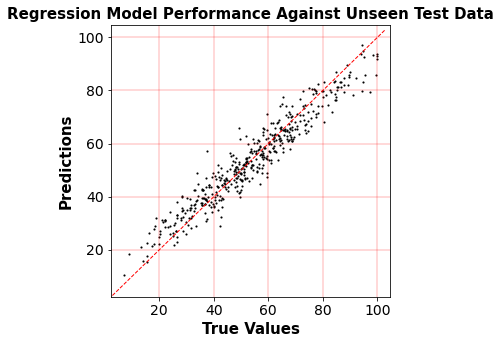


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:38:45
 - results:
   optimal int array: [29, 28, 3, 4, 5]
   predicted optimal output: 59.9282

Step 5: running 200 optimal runs
   (actual output value: 63.999)
- results saved to run_results.csv
- complete 2022-03-21 12:38:46

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1198,31,12,8,19,22,60.073709,1785
658,15,29,6,3,34,59.996492,1800
1041,31,2,37,28,1,60.216742,1810



- results scatter plot


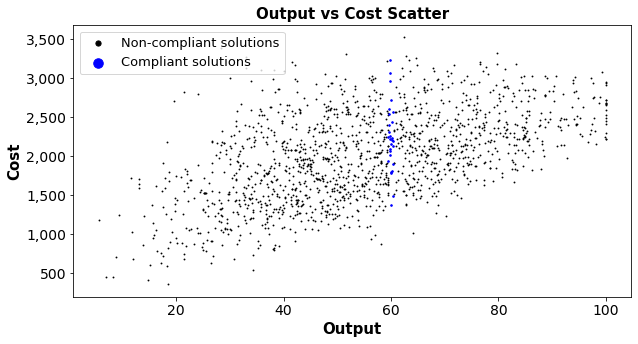

- presenting reduction in compliant solution costs over time


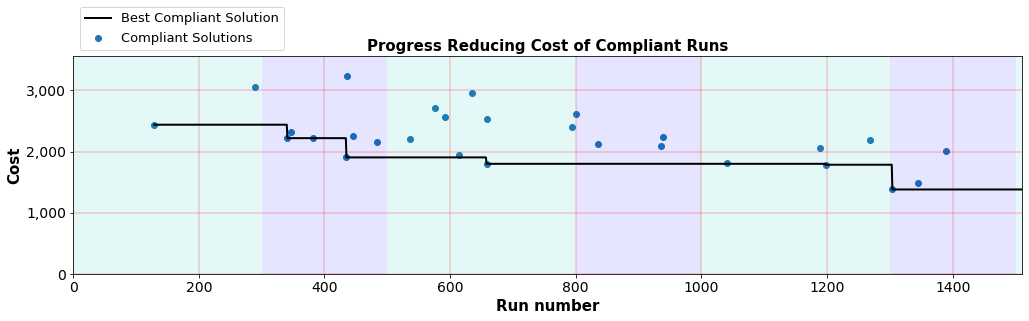

- presenting heatmap of top compliant solutions


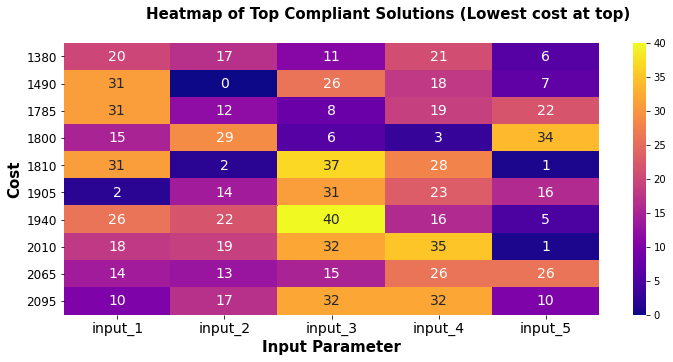


loop: 6

Step 0: imported 1510 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1198,31,12,8,19,22,60.073709,1785
658,15,29,6,3,34,59.996492,1800
1041,31,2,37,28,1,60.216742,1810



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:38:49

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,15,0,36,22,7,47.631265,1630
296,20,24,2,4,14,48.388760,1120
297,34,24,3,22,1,59.267526,1340
298,38,24,17,11,2,43.527535,1415
299,5,13,9,11,5,19.015092,850



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:39:24

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:39:28


,cv_mean,cv_std
hist_gradientboost,0.902796,0.007563
knn,0.581360,0.012228
svr,0.578757,0.011748


- best_regressor: hist_gradientboost


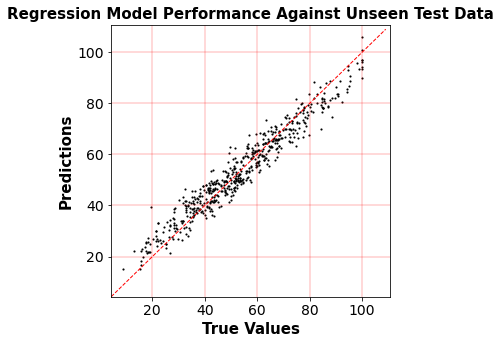


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:39:45
 - results:
   optimal int array: [24, 27, 2, 20, 1]
   predicted optimal output: 60.7754

Step 5: running 200 optimal runs
   (actual output value: 62.7919)
- results saved to run_results.csv
- complete 2022-03-21 12:39:46

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1588,27,16,7,34,0,59.656033,1500
1645,23,5,26,14,18,59.847068,1715
1198,31,12,8,19,22,60.073709,1785



- results scatter plot


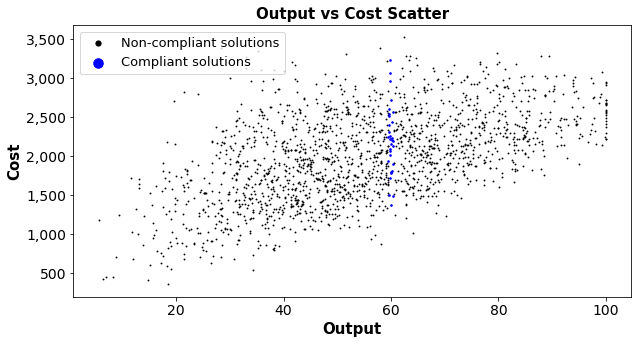

- presenting reduction in compliant solution costs over time


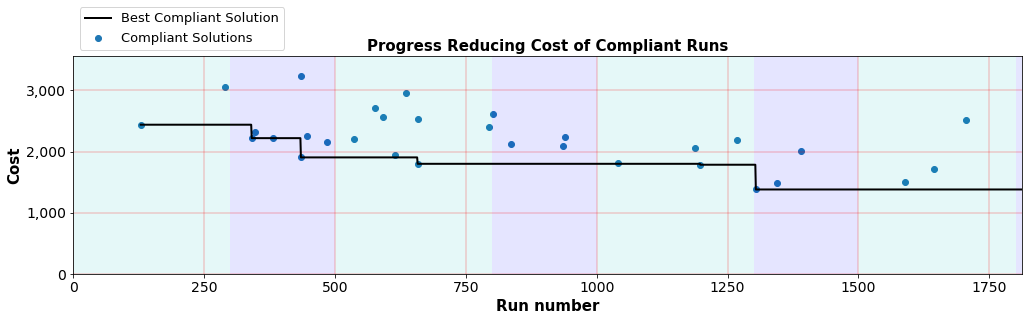

- presenting heatmap of top compliant solutions


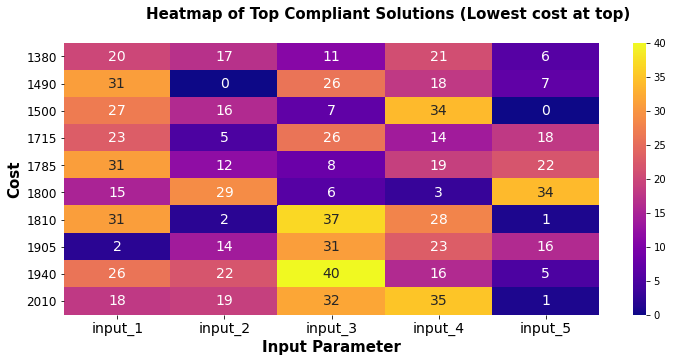


loop: 7

Step 0: imported 1812 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1588,27,16,7,34,0,59.656033,1500
1645,23,5,26,14,18,59.847068,1715
1198,31,12,8,19,22,60.073709,1785



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:39:49

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,8,27,9,8,17,48.843091,1375
296,2,30,39,37,31,58.632959,3105
297,1,37,23,0,24,41.653407,1745
298,33,34,18,15,33,81.320326,2565
299,36,9,11,11,38,20.001734,2130



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:40:28

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:40:32


,cv_mean,cv_std
hist_gradientboost,0.924846,0.001642
svr,0.587406,0.015070
knn,0.584380,0.013938


- best_regressor: hist_gradientboost


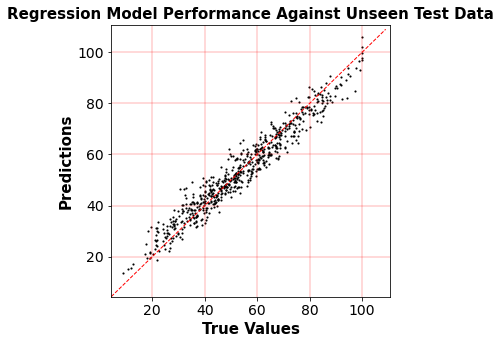


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:40:50
 - results:
   optimal int array: [29, 24, 19, 4, 4]
   predicted optimal output: 58.5512

Step 5: running 200 optimal runs
   (actual output value: 62.0646)
- results saved to run_results.csv
- complete 2022-03-21 12:40:51

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1588,27,16,7,34,0,59.656033,1500
2056,23,18,22,3,19,60.083576,1585
1645,23,5,26,14,18,59.847068,1715



- results scatter plot


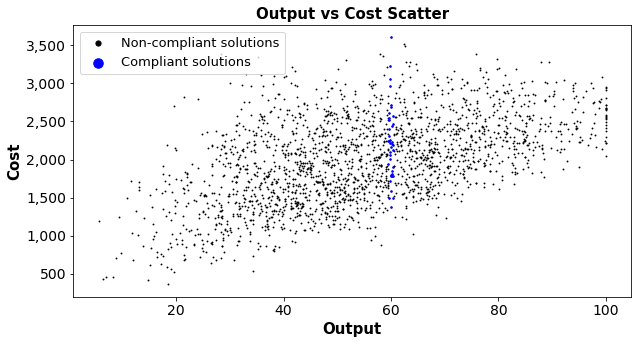

- presenting reduction in compliant solution costs over time


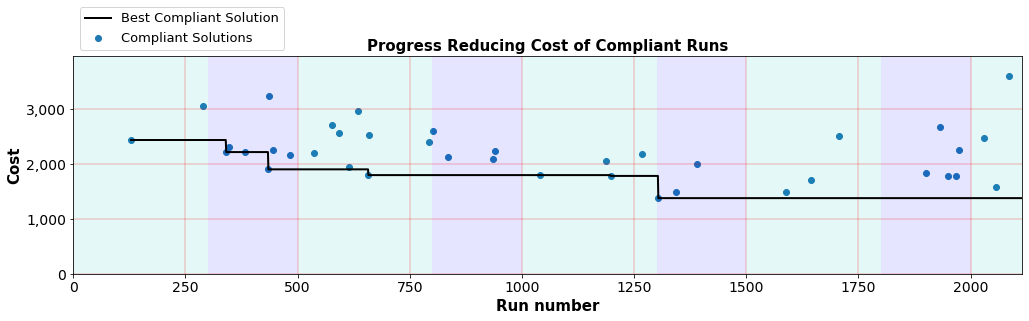

- presenting heatmap of top compliant solutions


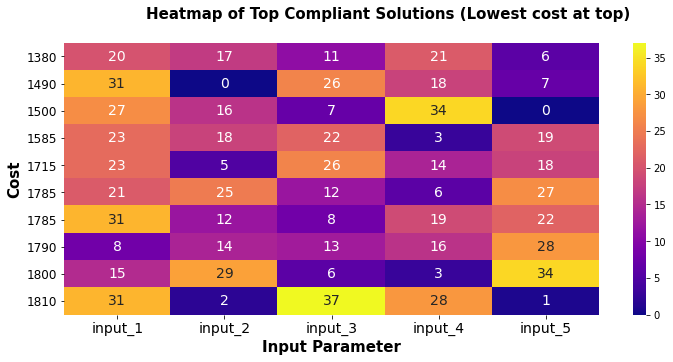


loop: 8

Step 0: imported 2114 rows of data from run_results.csv
- the existing best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1588,27,16,7,34,0,59.656033,1500
2056,23,18,22,3,19,60.083576,1585
1645,23,5,26,14,18,59.847068,1715



Step 1: running 300 exploratory runs
- complete 2022-03-21 12:40:55

- snapshot of last 5 exploratory runs:


,input_1,input_2,input_3,input_4,input_5,output,cost
295,33,18,21,12,8,62.240058,1560
296,23,29,33,26,1,76.763081,2005
297,36,6,12,20,5,39.624725,1340
298,12,29,26,22,40,71.585526,2825
299,31,4,21,26,36,74.334356,2520



Step 3: generating regression models
- running cross-validation gridsearch optimisation:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:41:34

- running 3-kfold cross-validation on training data:
 • svr
 • knn
 • hist_gradientboost
 - complete 2022-03-21 12:41:38


,cv_mean,cv_std
hist_gradientboost,0.930907,0.005727
svr,0.602970,0.014787
knn,0.599947,0.029255


- best_regressor: hist_gradientboost


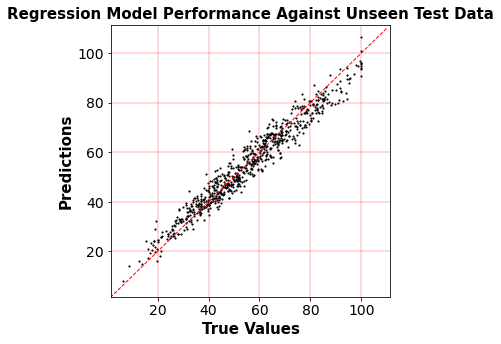


Step 4: determine optimal feature values from regression model to achieve target
 - complete 2022-03-21 12:41:55
 - results:
   optimal int array: [28, 16, 5, 17, 4]
   predicted optimal output: 59.7906

Step 5: running 200 optimal runs
   (actual output value: 67.6341)
- results saved to run_results.csv
- complete 2022-03-21 12:41:56

- the best compliant solutions are:


,input_1,input_2,input_3,input_4,input_5,output,cost
1304,20,17,11,21,6,60.071395,1380
1344,31,0,26,18,7,60.320258,1490
1588,27,16,7,34,0,59.656033,1500
2056,23,18,22,3,19,60.083576,1585
1645,23,5,26,14,18,59.847068,1715



- results scatter plot


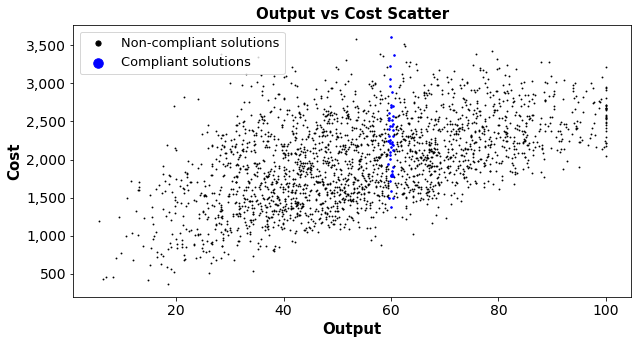

- presenting reduction in compliant solution costs over time


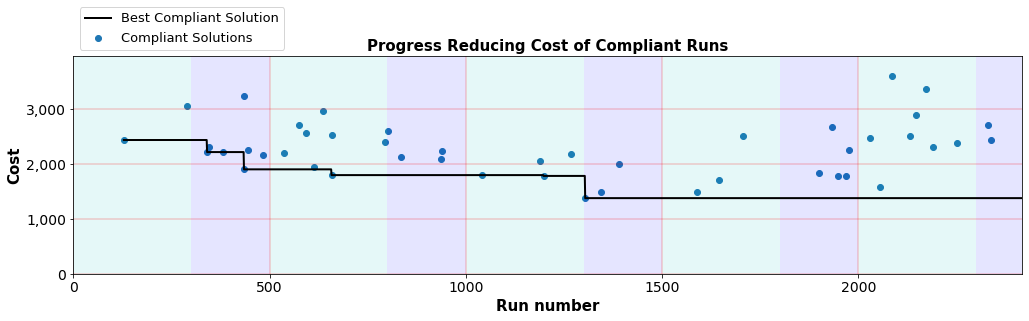

- presenting heatmap of top compliant solutions


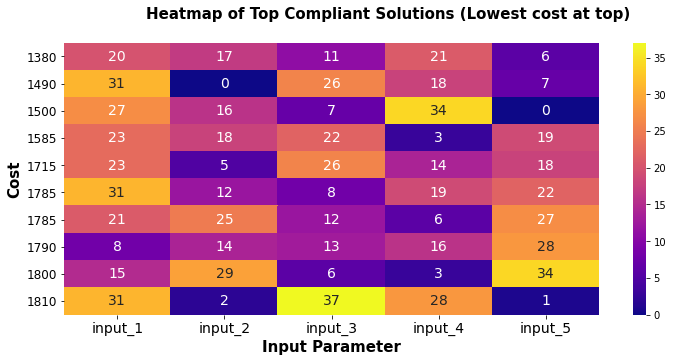

In [214]:
print('Program started {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
print(f'- target: {target} (tol: {target_tolerance})')

# Create x-values for banded shading on compliant results scatter plot
if os.path.exists('run_results.csv'):
    run_results_df_temp = pd.read_csv('run_results.csv').drop_duplicates(keep='first')
    run_results_df_len = len(run_results_df_temp.index)
else:    
    run_results_df_len = 0
    
# Execute loop for exploratory and optimal runs
for loop in range(num_loops):
    print('='*80)
    print(f'\nloop: {loop+1}')

    #==================================================================
    # **Import external csv**
    # This aims to represent the situation where an external (e.g. non-python simulator or real experiment) is being run.
    # Expected headers = input_1,input_2...output,cost.
    #==================================================================
    # Import the latest set of external results or create blank one
    if os.path.exists('run_results.csv'):
        imported_external_results = True
        run_results_df = pd.read_csv('run_results.csv').drop_duplicates(keep='first')
        
        print(f'\nStep 0: imported {len(run_results_df.index)} rows of data from run_results.csv')

        # Find current best compliant solution  
        compliant_run_results_extenal_df = run_results_df[(run_results_df['output']>target-target_tolerance) &\
                                  (run_results_df['output']<target+target_tolerance)].sort_values(by='cost')

        if len(compliant_run_results_extenal_df.index)>0:
            print('- the existing best compliant solutions are:')
            display(compliant_run_results_extenal_df.head(5))  
        else:
            print('- there are no compliant solutions in the external results file:')
    else:
        run_results_df = pd.DataFrame(columns=['input_'+str(i) for i in range(1,len(feature_costs)+1)]+['output']+['cost'])
        imported_external_results = False
        

    num_features = len(run_results_df.drop(columns=['output','cost']).columns)
    
    # Create data for scatter plot background shading
    section_breaks = [run_results_df_len] # Start with length of existing runs
    for r in range(num_loops):
        section_breaks.append(section_breaks[-1]+num_exploratory_runs)
        section_breaks.append(section_breaks[-1]+num_optimal_runs)
    
    section_break_diffs = list(np.diff(section_breaks))
    section_break_diffs.append(0)

    #==================================================================
    # **Run exploratory runs**
    # These cover the whole parameter value space
    # Purpose is to generate emulated experimental or simulator results
    # This whole step could be replaced by running an actual experiment that yields a single metric
    #==================================================================
    print(f'\nStep 1: running {num_exploratory_runs} exploratory runs')

    results_list = []
    for i in range(num_exploratory_runs):

        # Generate random inputs to explore solution landscape
        # Values are ints between feature min and max bounds
        random.seed()
        inputs = [randint(feature_mins[idx],feature_maxs[idx]) for idx in range(num_features)]

        # Run external black-box function - e.g. simulator or emulator 
        #*********
        output = simulation_emulator(inputs=inputs,funct_list=funct_list,scale=100,seed=0)
        #*********

        # Add output to end of inputs
        inputs.append(output)

        # Adds exploratory run results to results list
        results_list.append(inputs)

    # Generate dataframe of exploratory run results
    exploratory_run_results_df = pd.DataFrame(results_list,
                                             columns=['input_'+str(i) for i in range(1,num_features+1)]+['output'])

    # Add costs column to exploratory_run_results_df
    exploratory_run_results_df['cost'] = [sum(exploratory_run_results_df.drop(columns=['output','cost'],
                                                       errors='ignore').iloc[i,:]*feature_costs) for i in range(len(exploratory_run_results_df.index))]

    # Append to run_results_df
    run_results_df = run_results_df.append(exploratory_run_results_df,ignore_index=True)

    print('- complete {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

    print('\n- snapshot of last 5 exploratory runs:')
    display(exploratory_run_results_df.tail())

    # Find best compliant solution after exploratory runs, and display them 
    compliant_run_results_exploratory_df = run_results_df[(run_results_df['output']>target-target_tolerance) &\
                              (run_results_df['output']<target+target_tolerance)].sort_values(by='cost')

    if imported_external_results:
        # Determine whether any new compliant solutions have been found following exploratory runs
        compliant_run_results_improvement_df = compliant_run_results_exploratory_df[compliant_run_results_exploratory_df['cost']<compliant_run_results_extenal_df.head()['cost'].min()]

        if len(compliant_run_results_improvement_df.index)>0:
            print('- improvements in compliant results have been found:')
            display(compliant_run_results_improvement_df)

    else:
        if len(compliant_run_results_exploratory_df.index)>0:
            print('\n- the current best compliant solutions are:')
            display(compliant_run_results_exploratory_df.head(5)) 
        else:
            print('\n- there are no current compliant solutions')

    #==================================================================
    # **Build, optimise and test regression models**         
    #==================================================================
    print(f'\nStep 3: generating regression models')

    # Generate train and test data
    X = run_results_df.drop(columns=['cost','output'],errors='ignore').values
    y = run_results_df['output'].values.reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)
    y_train = y_train.ravel()

    #----------------------------------------------
    print('- running cross-validation gridsearch optimisation:')

    for regressor_pipe_name,values in regressor_pipe_all_dict.items():
        print(f' \u2022 {regressor_pipe_name}') # To generate bulleted list

        # Perform searchCV
        if search_type == 'grid':
            gridsearch = GridSearchCV(estimator=values['regressor_pipe'], 
                                      param_grid=values['pipe_search_params'],scoring=cv_scoring).fit(X_train, y_train)
        elif search_type == 'random':
            gridsearch = RandomizedSearchCV(estimator=values['regressor_pipe'],
                                            param_distributions=values['pipe_search_params'],
                                            scoring=cv_scoring,n_iter=randomizedsearch_cv_n_iter).fit(X_train, y_train)     

        # Update regressor with optimised parameters
        regressor_pipe_all_dict[regressor_pipe_name]['regressor_pipe'] = gridsearch.best_estimator_

    print(' - complete {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

    #==================================================================
    # **Perform k-fold cross-validation on training data**
    # Purpose is to rank regressors to find one with best performance on data
    #==================================================================

    print(f'\n- running {n_kfold_splits}-kfold cross-validation on training data:')

    regressor_perf_all_df = pd.DataFrame(columns=['cv_mean','cv_std'])

    for regressor_pipe_name in regressor_pipe_all_dict.keys():

        print(f' \u2022 {regressor_pipe_name}') 

        # Fit pipe
        pipe = regressor_pipe_all_dict[regressor_pipe_name]['regressor_pipe']
        pipe.fit(X_train, y_train)   

        # Cross-validation
        kfold = KFold(n_splits=n_kfold_splits)
        cross_val = cross_val_score(estimator=pipe,X=X_train,y=y_train, 
                                    cv=kfold,scoring=cv_scoring,n_jobs=-1)

        regressor_perf_all_df = regressor_perf_all_df.append(pd.DataFrame(data={'cv_mean':cross_val.mean(),
                                                                                'cv_std':cross_val.std()},
                                                                          index=[regressor_pipe_name]))

    print(' - complete {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

    display(regressor_perf_all_df.sort_values(by='cv_mean',ascending=False))

    # Identify the best regressor
    best_regressor_name = regressor_perf_all_df.sort_values(by='cv_mean',ascending=False).head(1).index[0]
    print(f'- best_regressor: {best_regressor_name}')


    # Plot performance of best regressor against test set
    y_pred = regressor_pipe_all_dict[best_regressor_name]['regressor_pipe'].predict(X_test)

    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.scatter(y_test,y_pred,marker='.',c='k',s=5)

    ax.set_ylim(min(ax.get_xlim()[0],ax.get_ylim()[0]),max(ax.get_xlim()[1],ax.get_ylim()[1]))
    ax.set_xlim(min(ax.get_xlim()[0],ax.get_ylim()[0]),max(ax.get_xlim()[1],ax.get_ylim()[1]))

    ax.plot(range(int(ax.get_xlim()[1])),range(int(ax.get_xlim()[1])),
            linestyle='--',linewidth='1',c='r')# The 45deg perfect performance line

    ax.set_xlabel('True Values', fontsize=15,weight='bold')
    ax.set_ylabel('Predictions', fontsize=15,weight='bold')
    ax.set_title('Regression Model Performance Against Unseen Test Data',fontsize=15,weight='bold');
    plt.tick_params(labelsize=14)
    ax.grid(linestyle='-',linewidth='0.3',color='r')
    plt.show()           

    #==================================================================
    # **Search regression model solution-space for best feature values**
    # 
    #==================================================================
    print(f'\nStep 4: determine optimal feature values from regression model to achieve target')

    # Execute solver
    # differential_evolution is an effective evolutionary algorithm-based global optimiser 
    result = differential_evolution(objective_function,
                                    bounds=[(a,b) for a,b in zip(feature_mins,feature_maxs)],
                                    args=tuple([regressor_pipe_all_dict[best_regressor_name]['regressor_pipe'],
                                               target,feature_costs,diff_error_weight,]*len(feature_costs)),
                                    maxiter=optimsation_diff_evol_maxiter)

    print(' - complete {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print(' - results:')

    # Extract optimal array
    x_optimal = result.x

    # Generate int values
    x_optimal_int = [int(round(x,0)) for x in x_optimal]
    print(f'   optimal int array: {[round(x,4) for x in list(x_optimal_int)]}')

    predicted_output = regressor_pipe_all_dict[best_regressor_name]['regressor_pipe'].predict([x_optimal_int])[0]
    print(f'   predicted optimal output: {round(predicted_output,4)}')

    #==================================================================
    # **Generate results on and around the predicted optimal feature set**
    # 
    #==================================================================
    print(f'\nStep 5: running {num_optimal_runs} optimal runs')

    random.seed()
    results_list = []

    for i in range(num_optimal_runs):

        if i == 0: # run the actual predicted optimal feature values
            inputs = [np.clip(x,feature_mins[idx],feature_maxs[idx]) for idx,x in enumerate(x_optimal_int)] 

        else: # Generate random inputs to explore solution landscape
            inputs = [np.clip(x+randint(-optimal_rand_int_perturbation,optimal_rand_int_perturbation),
                         feature_mins[idx],feature_maxs[idx]) for idx,x in enumerate(x_optimal_int)] 

        # Run external black-box function - e.g. simulator or emulator
        #*********
        output = simulation_emulator(inputs=inputs,funct_list=funct_list,scale=100,seed=0)
        #*********

        if i == 0:
            print(f'   (actual output value: {round(output,4)})')

        # Add output to end of inputs
        inputs.append(output)

        # Adds simulation run results to results list
        results_list.append(inputs)
        
    # Generate dataframe of optimal run results
    optimal_run_results_df = pd.DataFrame(results_list,
                                  columns=['input_'+str(i) for i in range(1,num_features+1)]+['output'])

    # Add costs column 
    optimal_run_results_df['cost'] = [sum(optimal_run_results_df.drop(columns=['output','cost'],
                                                       errors='ignore').iloc[i,:]*feature_costs) for i in range(len(optimal_run_results_df.index))]
    
    # Append optimal_run_results_df to existing results
    run_results_df = run_results_df.append(optimal_run_results_df,ignore_index=True).drop_duplicates(keep='first')
    
    # Overwrite external simulation run results file
    run_results_df.to_csv('run_results.csv', mode='w',index=False)
    print('- results saved to run_results.csv')
    print('- complete {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

    # ------------------------------------------------------------------------
    # Find current best compliant solution  
    compliant_run_results_df = run_results_df[(run_results_df['output']>target-target_tolerance) &\
                              (run_results_df['output']<target+target_tolerance)].sort_values(by='cost')

    if len(compliant_run_results_df.index)>0:
        print('\n- the best compliant solutions are:')
        display(compliant_run_results_df.head(5))  
    else:
        print('\n- there are no current compliant solutions:')

    # Determine the non-compliant solutions
    non_compliant_run_results_df = run_results_df[~run_results_df.isin(compliant_run_results_df)].dropna()

    # ------------------------------------------------------------------------
    # Plot scatter of output value vs cost
    print('\n- results scatter plot')
    fig, ax = plt.subplots(figsize=(10,5))

    ax.scatter(non_compliant_run_results_df['output'],non_compliant_run_results_df['cost'],
               label='Non-compliant solutions',marker='.',c='k',s=3)
    ax.scatter(compliant_run_results_df['output'],compliant_run_results_df['cost'],
               label='Compliant solutions',marker='.',c='b',s=10)

    ax.set_xlabel('Output', fontsize=15,weight='bold')
    ax.set_ylabel('Cost', fontsize=15,weight='bold')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tick_params(labelsize=14)
    ax.set_title('Output vs Cost Scatter',fontsize=15,weight='bold');   
    leg = ax.legend(fontsize=13,markerscale=6,loc ="upper left");                  
    plt.show()

    # ------------------------------------------------------------------------
    if len(compliant_run_results_df.index)>0: # plot progress of reduction in compliant solution cost over time

        print('- presenting reduction in compliant solution costs over time')

        compliance_progress_batch = []
        compliance_progress_min_cost = []

        # For successive expanding batches of compliant solutions, determine the lowest cost
        for batch in list(compliant_run_results_df.sort_index().index):
            compliance_progress_batch.append(batch)
            compliance_progress_min_cost.append(compliant_run_results_df.sort_index()[compliant_run_results_df.sort_index().index<=batch]['cost'].min())

        if max(run_results_df.index)>max(compliant_run_results_df.index):
            # Add final point at full extent of all conducted runs 
            compliance_progress_batch.append(run_results_df.index[-1])
            compliance_progress_min_cost.append(compliance_progress_min_cost[-1])         

        # Create df of actual compliance progress values
        compliance_progress_values_df = pd.DataFrame({'cost':compliance_progress_min_cost},index=compliance_progress_batch)

        # Resample index - to create more internal values
        resampled_index_list = list(set(list(range(0,max(compliance_progress_batch),1))+compliance_progress_batch))
        resampled_index_list = [int(x) for x in resampled_index_list]
        resampled_index_list.sort()

        # Generate resampled compliance progress df
        compliance_progress_values_df = pd.DataFrame(index=resampled_index_list).join(compliance_progress_values_df).fillna(method='ffill')

        fig, ax = plt.subplots(figsize=(17,4))    
        ax.plot(compliance_progress_values_df.index,
                compliance_progress_values_df['cost'], 
                label='Best Compliant Solution',
                linewidth='2',c='k');

        ax.scatter(x=compliant_run_results_df.index,
                   y=compliant_run_results_df['cost'], 
                   label='Compliant Solutions',
                   c='tab:blue');
        
        # Plot background shading - strips for exploratory and optimal runs
        ax.bar(section_breaks,[1.1*compliant_run_results_df['cost'].max()] * len(section_breaks),
               width=section_break_diffs,align='edge',color=['c','b'],alpha=0.1)

        ax.set_xlabel('Run number', fontsize=15,weight='bold')
        ax.set_ylabel('Cost', fontsize=15,weight='bold')
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        plt.tick_params(labelsize=14)
        ax.set_xlim(0,run_results_df.index.max()+1)
        ax.set_ybound(lower=0,upper=1.1*compliant_run_results_df['cost'].max())
        ax.set_title('Progress Reducing Cost of Compliant Runs',fontsize=15,weight='bold')
        ax.grid(linestyle='-',linewidth='0.3',color='r')

        ax.legend(bbox_to_anchor=(0, 1, 1, 0), fontsize=13,loc="lower left");
        plt.show()
    # ------------------------------------------------------------------------
        print('- presenting heatmap of top compliant solutions')

        # Plot heatmap of top compliant solutions.
        # This gives an impression of how diverse the compliant solutions can be
        fig, ax = plt.subplots(figsize=(12,5))
        sns.heatmap(data=compliant_run_results_df.iloc[:10,:].drop(columns=['output','cost']).astype(int), 
                    ax=ax,
                    annot=True,annot_kws={"fontsize":14},
                    cmap='plasma');

        fig.suptitle('Heatmap of Top Compliant Solutions (Lowest cost at top)',fontsize=15,weight='bold');
        ax.set_xlabel('Input Parameter', fontsize=15,weight='bold')
        ax.set_ylabel('Cost', fontsize=15,weight='bold')
        ax.set_yticklabels([str(x) for x in compliant_run_results_df['cost'].head(10)])
        ax.tick_params(axis = 'x', which = 'major', labelsize = 14)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 12,rotation=0)
        plt.show()
    # ------------------------------------------------------------------------